# Map Fishing Effort on the High Seas

In [1]:
import bq  
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

client = bq.Client.Get()

/Users/David/Desktop/Jobs/GlobalFishingWatch/github/vessel-maps/utilities/pipa_paper/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# create a bounding box:
max_lat = 85
min_lat = -80
max_lon = 180
min_lon = -180


# for the mapping
firstlat = max_lat
lastlat =  min_lat
firstlon = min_lon
lastlon = max_lon

# scale of the 
cellsize = .25
scale = cellsize
one_over_cellsize = 4

# num_lats = (max_lat-min_lat)*one_over_cellsize+1
# num_lons = (max_lon-min_lon)*one_over_cellsize+1
numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)

In [3]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [4]:
q = '''select 
sum(a.hours) hours,
IF(b.country IS NULL, "invalid mmsi",b.country) country,
from
(SELECT
  SUM(hours) hours,
  INTEGER(IF(LENGTH(STRING(mmsi))= 9,LEFT(STRING(mmsi),3), '0')) code
FROM
  TABLE_DATE_RANGE([pipeline_classify_logistic_715_fishing.], TIMESTAMP("2015-01-01"), TIMESTAMP("2015-12-31"))
WHERE
       lat > '''+str(min_lat)+'''
       AND lat <'''+str(max_lat)+'''
       AND lon > '''+str(min_lon)+'''
       AND lon < '''+str(max_lon)+'''
  AND measure_new_score >=.5  
  AND eez is null  
GROUP BY
  code)a
  left join 
   [scratch_roan.country_code] b
  ON
    a.code = b.code
    group by country
    order by hours desc'''
bycountry_hours = Query(q)

Waiting on bqjob_r19d8eaa33c1cd7cd_00000156c4151b36_1 ... (23s) Current status: DONE   
Query time: 28.6370439529 seconds.


In [5]:
for c in bycountry_hours:
    print int(float(c[0])),c[1]

818525 China (People's Republic of)
562345 Taiwan (Province of China) - China (People's Republic of)
464840 Japan
447843 Spain
225792 Korea (Republic of)
122669 Russian Federation
66730 Portugal
58831 Vanuatu (Republic of)
28920 Norway
28316 Latvia (Republic of)
22430 United States of America
20702 Azores - Portugal
19860 Mexico
18771 invalid mmsi
15704 Lithuania (Republic of)
15231 Seychelles (Republic of)
14105 Ecuador
13117 Fiji (Republic of)
11822 Belize
11330 Malaysia
9845 Colombia (Republic of)
9737 Panama (Republic of)
9095 Chile
9064 Estonia (Republic of)
8637 Papua New Guinea
8216 France
6976 Faroe Islands - Denmark
6743 Marshall Islands (Republic of the)
6449 Madeira - Portugal
6011 Ukraine
5662 Germany (Federal Republic of)
5056 United Kingdom of Great Britain and Northern Ireland
4870 Micronesia (Federated States of)
4752 Canada
3663 Thailand
3166 Venezuela (Bolivarian Republic of)
3035 Kiribati (Republic of)
2863 Iceland
2595 New Zealand
2305 Netherlands (Kingdom of the)
2

In [6]:
tots = np.array([int(float(c[0])) for c in bycountry_hours])
print tots[0:5].sum()/float(tots.sum())


0.804333098356


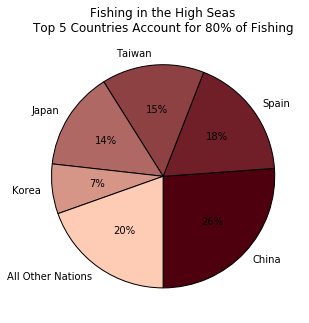

In [7]:
labels = country_names = ["China","Spain","Taiwan","Japan","Korea","All Other Nations"]
sizes = list(tots[0:5]) #+ [tots[5:].sum()]
sizes.append(tots[5:].sum())
thecolors = ['#2A4879', '#335691', '#3964A8', '#607FBA','#8DA1CA', '#B5C1DB'] 
thecolors = ["#4E000E","#701F29","#8E4143","#AF6864","#D59587","#FECBB5"]
plt.rcParams["figure.figsize"] = [5,5]


# explode = (0, 0, 0, 0)    # proportion with which to offset each wedge

plt.pie(sizes,              # data
#         explode=explode,    # offset parameters 
        labels=labels,      # slice labels
        colors=thecolors,      # array of colours
        autopct='%1.f%%',  # print the values inside the wedges
#         shadow=True,        # enable shadow
        startangle=270       # starting angle
        )
plt.title("Fishing in the High Seas\nTop 5 Countries Account for 80% of Fishing")
plt.savefig("piechart.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()

In [22]:
top_countries = ["China (People's Republic of)", "Spain",
                 "Taiwan (Province of China) - China (People's Republic of)",
                 "Japan", "Korea (Republic of)"]
country_names = ["China","Spain","Taiwan","Japan","Korea"]

country_query_string = '''("China (People's Republic of)", "Spain",
                 "Taiwan (Province of China) - China (People's Republic of)",
                 "Japan", "Korea (Republic of)")'''

In [10]:
def get_area(lat):
    lat_degree = 69 # miles
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0        
    # phi = 90 - latitude
    phi = (lat+cellsize/2.)*degrees_to_radians #plus half a cell size to get the middle
    lon_degree = math.cos(phi)*lat_degree 
    # return 69*69*2.6
    return  lat_degree*lon_degree* 2.58999 # miles to square km

In [15]:
get_area(lat*float(cellsize))*cellsize*cellsize 

25.21607033306003

In [16]:
def get_grid(c,allcountries=False):
    if allcountries:
        extra = 'where b.country not in '+ country_query_string
    else:
        extra = 'where b.country = "'+c+'"'

    q = '''select 
    a.lat_bin lat_bin,
    a.lon_bin lon_bin,
    sum(a.hours) hours,
    // IF(b.country IS NULL, "invalid mmsi",b.country) country,
    from
    (SELECT
      INTEGER(FLOOR(lat*4)) lat_bin,
      INTEGER(FLOOR(lon*4)) lon_bin,
      SUM(hours*measure_new_score) hours,
      INTEGER(IF(LENGTH(STRING(mmsi))= 9,LEFT(STRING(mmsi),3), '0')) code
    FROM
      (select lat, lon, mmsi, measure_new_score, hours, seg_id from
      TABLE_DATE_RANGE([pipeline_classify_logistic_715_fishing.], TIMESTAMP("2015-01-01"), TIMESTAMP("2015-12-31"))
    WHERE
           lat > '''+str(min_lat)+'''
           AND lat <'''+str(max_lat)+'''
           AND lon > '''+str(min_lon)+'''
           AND lon < '''+str(max_lon)+'''
      AND measure_new_score >=.5  
      and eez is null)
   where seg_id NOT IN ( // eliminate clearly bad segments
  SELECT
    seg_id
  FROM
    [scratch_david_seg_analysis_715.2015_segments]
  WHERE
    (point_count<20
      AND terrestrial_positions = point_count)
    OR ((min_lon >= 0 // these are almost definitely noise
        AND max_lon <= 0.109225)
      OR (min_lat >= 0
        AND max_lat <= 0.109225) ))
      and mmsi not in (412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093,412211691,
      412420276,412420917,411041815, 525018188, 412420276,412420561,533180156)
    GROUP BY
      lat_bin,
      lon_bin,
      code)a
      left join 
       [scratch_roan.country_code] b
      ON
        a.code = b.code
        '''+extra+'''
       group by lat_bin, lon_bin'''
#     print q
    fishing_bined = Query(q)

    grid = np.zeros(shape=(numlats,numlons))

    for row in fishing_bined:
        lat = int(row[0])
        lon = int(row[1])
        lat_index = lat-min_lat*one_over_cellsize
        lon_index = lon-min_lon*one_over_cellsize
        area = get_area(lat*float(cellsize))*cellsize*cellsize          
        grid[lat_index][lon_index] = float(row[2])/ area
        
    return grid


In [17]:
all_grids = []
for i in range(5):
    all_grids.append(get_grid(top_countries[i]))

Waiting on bqjob_r60abbb3df08c5b22_00000156c42005c8_2 ... (34s) Current status: DONE   
Query time: 39.8462519646 seconds.
Waiting on bqjob_r585f574267e6d115_00000156c420a1db_3 ... (34s) Current status: DONE   
Query time: 40.2228229046 seconds.
Waiting on bqjob_r38c5a17a6609a3ae_00000156c4213f6c_4 ... (34s) Current status: DONE   
Query time: 39.4239020348 seconds.
Waiting on bqjob_r4b0a961eea3d2d51_00000156c421d9d1_5 ... (34s) Current status: DONE   
Query time: 39.5710520744 seconds.
Waiting on bqjob_r3dc972b2d47560f8_00000156c42274cb_6 ... (34s) Current status: DONE   
Query time: 38.5220088959 seconds.


In [18]:
all_grids.append(get_grid("",True))

Waiting on bqjob_r659dd0d055af322d_00000156c42572d9_7 ... (34s) Current status: DONE   
Query time: 41.2140300274 seconds.


Waiting on bqjob_r70ee2c3a0bfa74ac_00000155f16f4cd4_74 ... (0s) Current status: DONE   
Query time: 4.94231104851 seconds.
Waiting on bqjob_r4726d6e4fe2a4254_00000155f1701231_75 ... (0s) Current status: DONE   
Query time: 3.83542394638 seconds.
Waiting on bqjob_r7f3d4a9ed5632ad7_00000155f1709c10_76 ... (0s) Current status: DONE   
Query time: 3.94815707207 seconds.
Waiting on bqjob_r5610b2329c8da191_00000155f1713ccf_77 ... (0s) Current status: DONE   
Query time: 3.51224589348 seconds.
Waiting on bqjob_r7305c04db10d8e2_00000155f171c7af_78 ... (0s) Current status: DONE   
Query time: 3.11315393448 seconds.
Waiting on bqjob_r566167f50cdadf7a_00000155f1725000_79 ... (0s) Current status: DONE   
Query time: 4.83083415031 seconds.


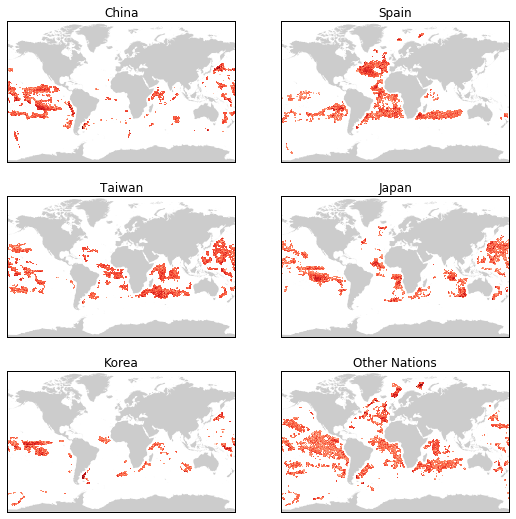

In [97]:
x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

plt.figure(1)

fig_max_value = 1500
fig_min_value = .01
plt.rcParams["figure.figsize"] = [9,14]
# fig = plt.figure()
# st = fig.suptitle("Fishing in the High Seas by Country", fontsize="x-large")

for i in range(5):
    fig_title = country_names[i]
    thegrid = get_grid(top_countries[i])
    plt.subplot(421+i)
    m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
              llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")
    m.drawmapboundary()#fill_color='#111111')
    m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
    converted_x, converted_y = m(x, y)
    maximum = fig_max_value 
    minimum = fig_min_value 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    m.pcolormesh(converted_x, converted_y, thegrid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('Reds'))
    plt.title(fig_title, color = "#000000", fontsize=12)
    plt.grid(True)
    

fig_title = "Other Nations"
thegrid = get_grid("",True)
plt.subplot(426)
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")
m.drawmapboundary()#fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
converted_x, converted_y = m(x, y)
maximum = fig_max_value 
minimum = fig_min_value 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
m.pcolormesh(converted_x, converted_y, thegrid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('Reds'))
plt.title("Other Nations", color = "#000000", fontsize=12)
plt.grid(True)
    

# ax = fig.add_axes([0.2, 0.1, 0.6, 0.02]) #x coordinate , 
# norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
# cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('Reds'))
# cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
# cb.set_label('Fishing Hours',labelpad=-40, y=0.45, color = "#000000")

# shift subplots down:
# st.set_y(0.95)
# fig.subplots_adjust(top=0.85)

plt.savefig("HighSeasFishing.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()

In [20]:
'''Make a custom colormap'''

tm = 255
thecolors = [['#FDD0BD',0,0], # a small vaiation on 'Reds' colormap
          ['#620110',255,255]]
cdict = { 'red':tuple(   (color[2]/tm, int(color[0][1:3],16)/256.0, int(color[0][1:3],16)/256.0) for color in thecolors ),
      'green':tuple( (color[2]/tm, int(color[0][3:5],16)/256.0, int(color[0][3:5],16)/256.0) for color in thecolors ),
      'blue':tuple(  (color[2]/tm, int(color[0][5:7],16)/256.0, int(color[0][5:7],16)/256.0) for color in thecolors )}

mycmap = colors.LinearSegmentedColormap('my_colormap',cdict,256)


thecolors = [['#FDD0BD',0,0], # a small vaiation on 'Reds' colormap
          ['#62000C',255,255]]
cdict = { 'red':tuple(   (color[2]/tm, int(color[0][1:3],16)/256.0, int(color[0][1:3],16)/256.0) for color in thecolors ),
      'green':tuple( (color[2]/tm, int(color[0][3:5],16)/256.0, int(color[0][3:5],16)/256.0) for color in thecolors ),
      'blue':tuple(  (color[2]/tm, int(color[0][5:7],16)/256.0, int(color[0][5:7],16)/256.0) for color in thecolors )}

mycmap_redder = colors.LinearSegmentedColormap('my_colormap',cdict,256)


In [81]:
x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

plt.figure(1)

fig_max_value = 1000
fig_min_value = .01
plt.rcParams["figure.figsize"] = [9,14]
# fig = plt.figure()
# st = fig.suptitle("Fishing in the High Seas by Country", fontsize="x-large")

for i in range(5):
    fig_title = country_names[i]
    thegrid = get_grid(top_countries[i])
    plt.subplot(421+i)
    m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
              llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")
    m.drawmapboundary()#fill_color='#111111')
    m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
    converted_x, converted_y = m(x, y)
    maximum = fig_max_value 
    minimum = fig_min_value 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    m.pcolormesh(converted_x, converted_y, thegrid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('Reds'))
    plt.title(fig_title, color = "#000000", fontsize=12)
    plt.grid(True)
    

fig_title = "Other Nations"
thegrid = get_grid("",True)
plt.subplot(426)
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")
m.drawmapboundary()#fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
converted_x, converted_y = m(x, y)
maximum = fig_max_value 
minimum = fig_min_value 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
m.pcolormesh(converted_x, converted_y, thegrid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('Reds'))
plt.title("Other Nations", color = "#000000", fontsize=12)
plt.grid(True)
    

# ax = fig.add_axes([0.2, 0.1, 0.6, 0.02]) #x coordinate , 
# norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
# cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('Reds'))
# cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
# cb.set_label('Fishing Hours',labelpad=-40, y=0.45, color = "#000000")

# shift subplots down:
# st.set_y(0.95)
# fig.subplots_adjust(top=0.85)

plt.savefig("HighSeasFishing2.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()

select 
    a.lat_bin lat_bin,
    a.lon_bin lon_bin,
    sum(a.hours) hours,
    // IF(b.country IS NULL, "invalid mmsi",b.country) country,
    from
    (SELECT
      INTEGER(FLOOR(lat*4)) lat_bin,
      INTEGER(FLOOR(lon*4)) lon_bin,
      SUM(hours*measure_new_score) hours,
      INTEGER(IF(LENGTH(STRING(mmsi))= 9,LEFT(STRING(mmsi),3), '0')) code
    FROM
      TABLE_DATE_RANGE([pipeline_classify_logistic_661b_fishing.], TIMESTAMP("2014-07-01"), TIMESTAMP("2015-06-30"))
    WHERE
           lat > -80
           AND lat <85
           AND lon > -180
           AND lon < 180
      AND measure_new_score >=.5  
      and eez is null
    GROUP BY
      lat_bin,
      lon_bin,
      code)a
      left join 
       [scratch_roan.country_code] b
      ON
        a.code = b.code
        where b.country not in ("China (People's Republic of)", "Spain",
                 "Taiwan (Province of China) - China (People's Republic of)",
                 "Japan", "Korea (Republic of)")
       group by 

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

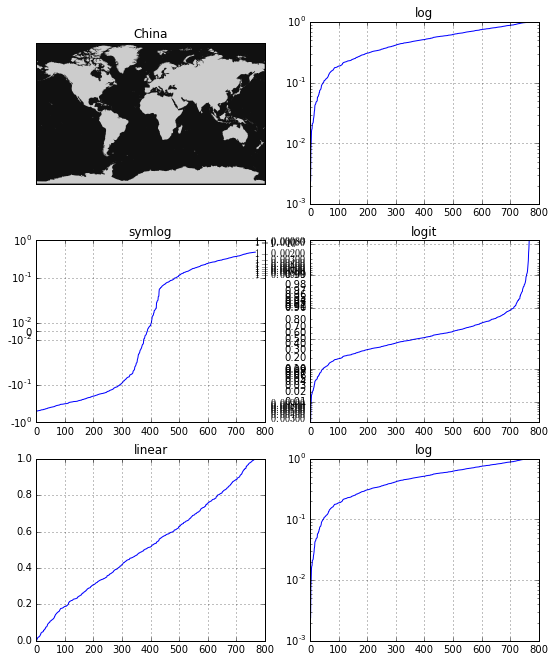

In [91]:
plt.rcParams["figure.figsize"] = [9,15]

# make up some data in the interval ]0, 1[
y = np.random.normal(loc=0.5, scale=0.4, size=1000)
y = y[(y > 0) & (y < 1)]
y.sort()
x = np.arange(len(y))

# plot with various axes scales
plt.figure(1)

# linear
plt.subplot(421)
m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
          llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="h")
m.drawmapboundary(fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
plt.title("China")
plt.grid(True)

# log
plt.subplot(422)
plt.plot(x, y)
plt.yscale('log')
plt.title('log')
plt.grid(True)


# symmetric log
plt.subplot(423)
plt.plot(x, y - y.mean())
plt.yscale('symlog', linthreshy=0.05)
plt.title('symlog')
plt.grid(True)

# logit
plt.subplot(424)
plt.plot(x, y)
plt.yscale('logit')
plt.title('logit')
plt.grid(True)


# linear
plt.subplot(425)
plt.plot(x, y)
plt.yscale('linear')
plt.title('linear')
plt.grid(True)


# log
plt.subplot(426)
plt.plot(x, y)
plt.yscale('log')
plt.title('log')
plt.grid(True)



# plt.grid(True)

plt.savefig("temp.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)


plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [10,10]
fig = plt.figure()

gs = gridspec.GridSpec(3, 2, wspace=0.05, hspace=0.10)

ax1 = plt.subplot(gs[0])

m = Basemap(llcrnrlat=-85, urcrnrlat=85,
          llcrnrlon=-180+lon_offset, urcrnrlon=180+lon_offset, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
plt.title("China")

ax2 = plt.subplot(gs[1])

m = Basemap(llcrnrlat=-85, urcrnrlat=85,
          llcrnrlon=-180+lon_offset, urcrnrlon=180+lon_offset, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary(fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
plt.title("U.S.")


ax3 = plt.subplot(gs[2])

m = Basemap(llcrnrlat=-85, urcrnrlat=85,
          llcrnrlon=-180, urcrnrlon=180, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
plt.title("Argentina")


ax4 = plt.subplot(gs[3])

m = Basemap(llcrnrlat=-85, urcrnrlat=85,
          llcrnrlon=-180, urcrnrlon=180, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
plt.title("South Africa")

ax3 = plt.subplot(gs[4])

m = Basemap(llcrnrlat=-85, urcrnrlat=85,
          llcrnrlon=-180, urcrnrlon=180, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
plt.title("Argentina")


ax4 = plt.subplot(gs[5])

m = Basemap(llcrnrlat=-85, urcrnrlat=85,
          llcrnrlon=-180, urcrnrlon=180, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
plt.title("South Africa")


ax4 = fig.add_axes([0.95, 0.25, 0.025, 0.5]) #x coordinate ,#plt.subplot(gs[4:6])
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(np.log10(1),np.log10(1000),num=6)
cb = colorbar.ColorbarBase(ax4,norm = norm, orientation='vertical',ticks=lvls, cmap = mycmap)#plt.get_cmap('Reds'))#
cb.ax.set_yticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Nice Colorbar',labelpad=-65, y=0.45, color = "#000000")

fig.suptitle("Beautiful Maps", fontsize=20)
plt.subplots_adjust(top=0.92)

plt.show()

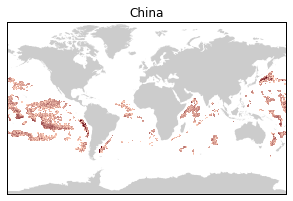

In [56]:
fig_min_value = 1
fig_max_value = 1000
x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)


fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()#fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
converted_x, converted_y = m(x, y)
maximum = fig_max_value 
minimum = fig_min_value 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
m.pcolormesh(converted_x, converted_y, all_girds[0], norm=norm, vmin=minimum, vmax=maximum, cmap = mycmap)# plt.get_cmap('Reds'))
plt.title("China", color = "#000000", fontsize=12)
plt.show()

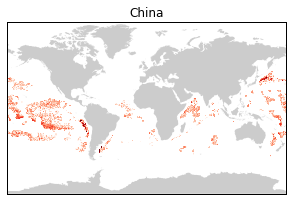

In [57]:
fig_min_value = 1
fig_max_value = 1000
x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)


fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()#fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
converted_x, converted_y = m(x, y)
maximum = fig_max_value 
minimum = fig_min_value 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
m.pcolormesh(converted_x, converted_y, all_girds[0], norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('Reds'))
plt.title("China", color = "#000000", fontsize=12)
plt.show()

In [23]:
country_names.append("All Other Nations")

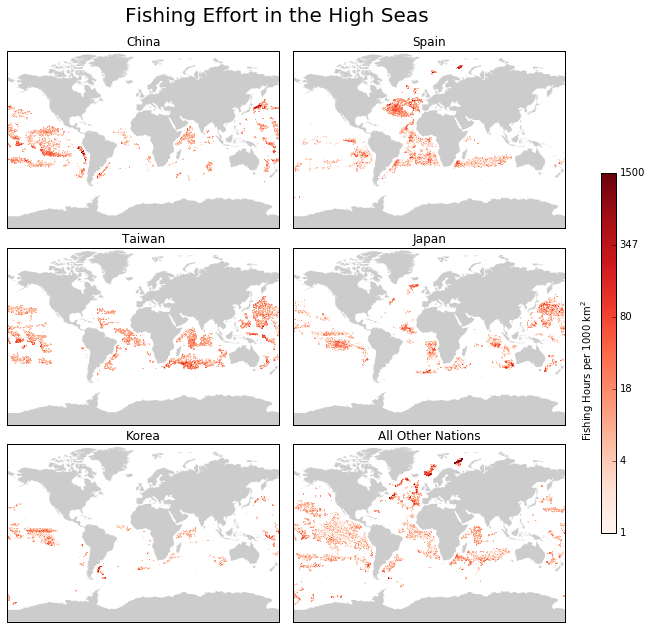

In [43]:
fig_min_value = 1
fig_max_value = 1500
lon_offset = 0
x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)


plt.rcParams["figure.figsize"] = [10,10]
fig = plt.figure()

gs = gridspec.GridSpec(3, 2, wspace=0.05, hspace=0.10)


for i in range(6):
    ax = plt.subplot(gs[i])
    m = Basemap(llcrnrlat=-85, urcrnrlat=85,
              llcrnrlon=-180+lon_offset, urcrnrlon=180+lon_offset, lat_ts=0, projection='mill',resolution="l")                  
    m.drawmapboundary()
    m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
    converted_x, converted_y = m(x, y)
    maximum = fig_max_value 
    minimum = fig_min_value 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    m.pcolormesh(converted_x, converted_y, all_grids[i]*1000, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('Reds'))# plt.get_cmap('Reds'))
    plt.title(country_names[i], color = "#000000", fontsize=12)


ax = fig.add_axes([0.95, 0.25, 0.02, 0.5]) #x coordinate
norm = colors.LogNorm(vmin=fig_min_value, vmax=fig_max_value)
lvls = np.logspace(np.log10(fig_min_value),np.log10(fig_max_value),num=6)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='vertical',ticks=lvls, cmap = plt.get_cmap('Reds')) # plt.get_cmap('Reds'))
cb.ax.set_yticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Hours per 1000 $\mathregular{km^{2}}$',labelpad=-65, y=0.45, color = "#000000")

fig.suptitle("Fishing Effort in the High Seas", fontsize=20)
plt.subplots_adjust(top=0.92)
plt.savefig("HighSeasFishing_reds.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()


In [30]:
all_fishing = np.zeros(shape=(numlats,numlons))
for g in all_grids:
    all_fishing = np.add(g,all_fishing)

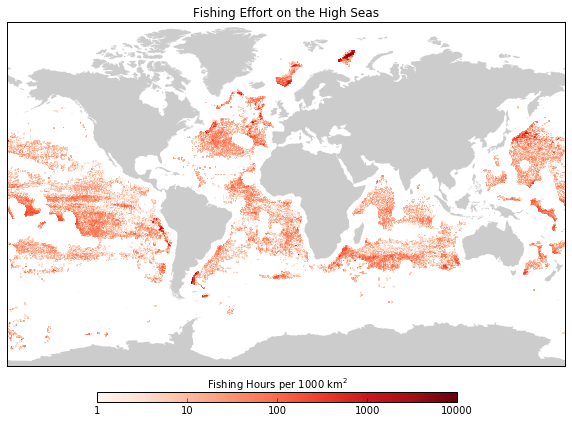

In [50]:
fig_min_value = 1
fig_max_value = 10000
lon_adjust = 0 # adjust to move the map
plt.rcParams["figure.figsize"] = [10,7]
x = np.linspace(firstlon+lon_adjust, lastlon+lon_adjust, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon+lon_adjust,lastlon+lon_adjust,num=numlons,endpoint=False)

offset_grid = np.zeros((numlats,numlons))

i = 0
pixel_offset = lon_adjust*one_over_cellsize
offset_grid[:,0:len(all_fishing[0]) - pixel_offset] = all_fishing[:,pixel_offset:len(all_fishing[0])] 
offset_grid[:,len(all_fishing[0]) - pixel_offset:len(all_fishing[0])] = all_fishing[:,0:pixel_offset]

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon+lon_adjust, urcrnrlon=lastlon+lon_adjust, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()#fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
converted_x, converted_y = m(x, y)
maximum = fig_max_value 
minimum = fig_min_value 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
m.pcolormesh(converted_x, converted_y, offset_grid*1000, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('Reds'))
plt.title("Fishing Effort on the High Seas", color = "#000000", fontsize=12)

ax = fig.add_axes([0.25, 0.1, 0.5, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=fig_min_value, vmax=fig_max_value)
lvls = np.logspace(np.log10(fig_min_value),np.log10(fig_max_value),num=5)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal',ticks=lvls, cmap = plt.get_cmap('Reds')) # plt.get_cmap('Reds'))
cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Hours per 1000 $\mathregular{km^{2}}$',labelpad=-40, y=0.45, color = "#000000")

plt.show()

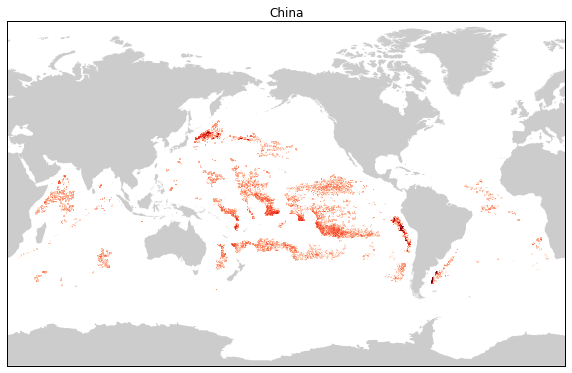

In [116]:
fig_min_value = 1
fig_max_value = 1000
lon_adjust = 205
x = np.linspace(firstlon+lon_adjust, lastlon+lon_adjust, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon+lon_adjust,lastlon+lon_adjust,num=numlons,endpoint=False)

offset_grid = np.zeros((numlats,numlons))

i = 0
pixel_offset = lon_adjust*one_over_cellsize
offset_grid[:,0:len(all_grids[i][0]) - pixel_offset] = all_grids[i][:,pixel_offset:len(all_grids[i][0])] 
offset_grid[:,len(all_grids[i][0]) - pixel_offset:len(all_grids[i][0])] = all_grids[i][:,0:pixel_offset]

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon+lon_adjust, urcrnrlon=lastlon+lon_adjust, lat_ts=0, projection='mill',resolution="l")
m.drawmapboundary()#fill_color='#111111')
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
converted_x, converted_y = m(x, y)
maximum = fig_max_value 
minimum = fig_min_value 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
m.pcolormesh(converted_x, converted_y, offset_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('Reds'))
plt.title("China", color = "#000000", fontsize=12)
plt.show()

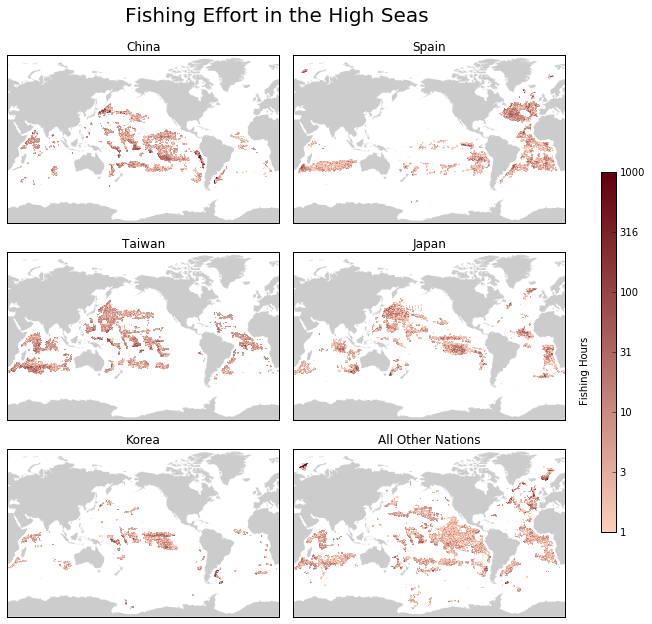

In [124]:
fig_min_value = 1
fig_max_value = 1000
lon_adjust = 205
x = np.linspace(firstlon+lon_adjust, lastlon+lon_adjust, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)

lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon+lon_adjust,lastlon+lon_adjust,num=numlons,endpoint=False)

pixel_offset = lon_adjust*one_over_cellsize

plt.rcParams["figure.figsize"] = [10,10]
fig = plt.figure()
gs = gridspec.GridSpec(3, 2, wspace=0.05, hspace=0.10)


for i in range(6):
    offset_grid = np.zeros((numlats,numlons))
    offset_grid[:,0:len(all_grids[i][0]) - pixel_offset] = all_grids[i][:,pixel_offset:len(all_grids[i][0])] 
    offset_grid[:,len(all_grids[i][0]) - pixel_offset:len(all_grids[i][0])] = all_grids[i][:,0:pixel_offset]
    ax = plt.subplot(gs[i])
    m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
              llcrnrlon=firstlon+lon_adjust, urcrnrlon=lastlon+lon_adjust, lat_ts=0, projection='mill',resolution="l")                
    m.drawmapboundary()
    m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
    maximum = fig_max_value 
    minimum = fig_min_value 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    m.pcolormesh(converted_x, converted_y, offset_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = mycmap_redder)# plt.get_cmap('Reds'))
    plt.title(country_names[i], color = "#000000", fontsize=12)


ax = fig.add_axes([0.95, 0.25, 0.02, 0.5]) #x coordinate
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(np.log10(1),np.log10(1000),num=7)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='vertical',ticks=lvls, cmap = mycmap_redder)#plt.get_cmap('Reds'))
cb.ax.set_yticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Hours',labelpad=-65, y=0.45, color = "#000000")

fig.suptitle("Fishing Effort in the High Seas", fontsize=20)
plt.subplots_adjust(top=0.92)
plt.savefig("HighSeasFishing_reds_oceans.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()

In [ ]:
fig_min_value = 1
fig_max_value = 1000
lon_offset = 0
x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)


plt.rcParams["figure.figsize"] = [10,10]
fig = plt.figure()

gs = gridspec.GridSpec(3, 2, wspace=0.05, hspace=0.10)

for i in range(6):
    ax = plt.subplot(gs[i])
    m = Basemap(llcrnrlat=-85, urcrnrlat=85,
              llcrnrlon=-180+lon_offset, urcrnrlon=180+lon_offset, lat_ts=0, projection='mill',resolution="l")                  
    m.drawmapboundary()
    m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)
    converted_x, converted_y = m(x, y)
    maximum = fig_max_value 
    minimum = fig_min_value 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    m.pcolormesh(converted_x, converted_y, all_grids[i], norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('Reds'))
    plt.title(country_names[i], color = "#000000", fontsize=12)


ax = fig.add_axes([0.95, 0.25, 0.02, 0.5]) #x coordinate
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(np.log10(1),np.log10(1000),num=7)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='vertical',ticks=lvls, cmap = plt.get_cmap('Reds'))
cb.ax.set_yticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Hours',labelpad=-65, y=0.45, color = "#000000")

fig.suptitle("Fishing Effort in the High Seas", fontsize=20)
plt.subplots_adjust(top=0.92)
plt.savefig("HighSeasFishing_reds.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()